# Understanding Model Bias vs. Data Bias

**Data Bias**: Occurs when the training data is not representative of the real-world scenario, leading to skewed learning.
**Model Bias**: Arises from the algorithms and methodologies used to train the model, causing systematic errors favoring one outcome over others.

# Objective
We'll identify and address model bias in the Wine dataset, focusing on techniques to mitigate bias resulting from class imbalance.

# Steps

1. **Load and preprocess the Wine dataset**.
2. **Train a biased model** to demonstrate preference for the majority class.
3. **Apply four different techniques** to mitigate this bias.
4. **Evaluate and compare** results quantitatively and qualitatively.

# Step 1: Import Libraries and Load Data
We import necessary libraries and load the Wine dataset. The data is preprocessed, including standardization and conversion to PyTorch tensors.

# Step 2: Define the Model
A simple neural network model is defined using PyTorch for classifying the Wine dataset into three classes.

# Step 3: Train the Biased Model
We train the model using the training dataset, monitoring the loss over epochs to ensure the model is learning.

# Step 4: Evaluate the Biased Model
The model is evaluated using the test dataset. Accuracy, classification report, and confusion matrix are displayed to understand the model's performance.

# Step 5: Mitigation Techniques
We apply four different bias correction methods to the Wine dataset and retrain the model with each method:

### Method 1: Reweighting
Adjust the loss function to give different weights to classes based on their frequency in the training data.

### Method 2: Oversampling
Create more samples of the minority classes by duplicating existing samples, ensuring equal representation of each class.

### Method 3: Undersampling
Reduce the number of samples from the majority class to match the minority class, balancing class distribution.

### Method 4: Synthetic Minority Over-sampling Technique (SMOTE)
Generate synthetic samples for the minority classes by interpolating between existing samples, balancing class distribution while preserving diversity.

# Results
For each method, retrain the model and evaluate its performance on the test dataset. Display accuracy and classification report to compare the effectiveness of each bias correction method.


# Step 1: Import Libraries and Load Data
We import necessary libraries and load the Wine dataset. The data is preprocessed, including standardization and conversion to PyTorch tensors.

In [1]:
# # Import necessary libraries
# import pandas as pd
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import accuracy_score, classification_report
# from torch.utils.data import DataLoader, TensorDataset

# # Load Wine dataset
# url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data"
# column_names = [
#     'Class', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium',
#     'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
#     'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline'
# ]
# wine_data = pd.read_csv(url, header=None, names=column_names)

# # Split data into features and target
# X = wine_data.drop('Class', axis=1).values
# y = wine_data['Class'].values - 1  # Classes need to be zero-indexed for PyTorch

# # Split into training and test sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# # Standardize the data
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# # Convert to PyTorch tensors
# X_train = torch.tensor(X_train, dtype=torch.float32)
# y_train = torch.tensor(y_train, dtype=torch.long)
# X_test = torch.tensor(X_test, dtype=torch.float32)
# y_test = torch.tensor(y_test, dtype=torch.long)

# # Create DataLoader
# train_dataset = TensorDataset(X_train, y_train)
# test_dataset = TensorDataset(X_test, y_test)
# train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [5]:
# Import necessary libraries
import pandas as pd
import urllib.request
import os
from pyspark.sql import SparkSession
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import DataLoader, TensorDataset
# # Import necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from torch.utils.data import DataLoader, TensorDataset

# Define URLs for the datasets
red_wine_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
white_wine_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"

# Define local paths for saving the datasets
local_red_wine_path = "./data/datasets/winequality-red.csv"
local_white_wine_path = "./data/datasets/winequality-white.csv"

# Create directories if they do not exist
os.makedirs(os.path.dirname(local_red_wine_path), exist_ok=True)

# Download the datasets
urllib.request.urlretrieve(red_wine_url, local_red_wine_path)
urllib.request.urlretrieve(white_wine_url, local_white_wine_path)

# Define column names
column_names = [
    'fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides',
    'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality'
]

# Initialize Spark session
spark = SparkSession.builder.appName("WineDataProcessing").getOrCreate()

# Read the CSV files using Spark with the correct delimiter
red_wine_data = spark.read.csv(local_red_wine_path, header=True, sep=';', inferSchema=True)
white_wine_data = spark.read.csv(local_white_wine_path, header=True, sep=';', inferSchema=True)

# Convert Spark DataFrames to Pandas DataFrames
red_wine_pd = red_wine_data.toPandas()
white_wine_pd = white_wine_data.toPandas()

# Add 'is_red' column
red_wine_pd['is_red'] = 1
white_wine_pd['is_red'] = 0

# Concatenate the datasets
wine_data = pd.concat([red_wine_pd, white_wine_pd], axis=0)

# Rename columns to replace spaces with underscores (if necessary)
wine_data.columns = wine_data.columns.str.replace('"', '').str.replace(';', '').str.replace(' ', '_')

# Check column names
print("Columns in the dataset:", wine_data.columns.tolist())

# Ensure the 'quality' column exists in the dataset
if 'quality' not in wine_data.columns:
    raise KeyError("'quality' column not found in dataset")

# Split data into features and target
X = wine_data.drop('quality', axis=1).values
y = wine_data['quality'].values - 1  # Classes need to be zero-indexed for PyTorch

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

print("Data processing completed successfully.")


Columns in the dataset: ['fixed_acidity', 'volatile_acidity', 'citric_acid', 'residual_sugar', 'chlorides', 'free_sulfur_dioxide', 'total_sulfur_dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality', 'is_red']
Data processing completed successfully.


# Step 2: Define the Model
A simple neural network model is defined using PyTorch for classifying the Wine dataset into three classes.

In [6]:
# Define a simple neural network
class WineClassifier(nn.Module):
    def __init__(self):
        super(WineClassifier, self).__init__()
        self.fc1 = nn.Linear(13, 50)
        self.fc2 = nn.Linear(50, 3)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model, criterion and optimizer
model = WineClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Step 3: Train the Biased Model
We train the model using the training dataset, monitoring the loss over epochs to ensure the model is learning.

In [8]:
for inputs, labels in train_loader:
    print(f'Input shape: {inputs.shape}')
    print(f'Label shape: {labels.shape}')
    break


Input shape: torch.Size([16, 12])
Label shape: torch.Size([16])


In [7]:
# # Training function
# def train_model(model, train_loader, criterion, optimizer, epochs=50):
#     model.train()
#     for epoch in range(epochs):
#         running_loss = 0.0
#         for inputs, labels in train_loader:
#             optimizer.zero_grad()
#             outputs = model(inputs)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item() * inputs.size(0)
#         epoch_loss = running_loss / len(train_loader.dataset)
#         print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

# # Train the model
# train_model(model, train_loader, criterion, optimizer, epochs=50)


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x12 and 13x50)

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim

class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Define input size, hidden size, and output size
input_size = 12  # Number of features
hidden_size = 50  # Number of neurons in hidden layer
output_size = 10  # Number of classes (adjust as needed)

# Instantiate the model
model = SimpleNN(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training function
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

# Train the model
train_model(model, train_loader, criterion, optimizer, epochs=50)


Epoch 1/50, Loss: 1.5746
Epoch 2/50, Loss: 1.2460
Epoch 3/50, Loss: 1.1789
Epoch 4/50, Loss: 1.1463
Epoch 5/50, Loss: 1.1242
Epoch 6/50, Loss: 1.1098
Epoch 7/50, Loss: 1.0981
Epoch 8/50, Loss: 1.0905
Epoch 9/50, Loss: 1.0837
Epoch 10/50, Loss: 1.0782
Epoch 11/50, Loss: 1.0736
Epoch 12/50, Loss: 1.0692
Epoch 13/50, Loss: 1.0663
Epoch 14/50, Loss: 1.0620
Epoch 15/50, Loss: 1.0601
Epoch 16/50, Loss: 1.0574
Epoch 17/50, Loss: 1.0542
Epoch 18/50, Loss: 1.0510
Epoch 19/50, Loss: 1.0502
Epoch 20/50, Loss: 1.0478
Epoch 21/50, Loss: 1.0458
Epoch 22/50, Loss: 1.0435
Epoch 23/50, Loss: 1.0419
Epoch 24/50, Loss: 1.0406
Epoch 25/50, Loss: 1.0390
Epoch 26/50, Loss: 1.0372
Epoch 27/50, Loss: 1.0356
Epoch 28/50, Loss: 1.0346
Epoch 29/50, Loss: 1.0323
Epoch 30/50, Loss: 1.0315
Epoch 31/50, Loss: 1.0301
Epoch 32/50, Loss: 1.0287
Epoch 33/50, Loss: 1.0272
Epoch 34/50, Loss: 1.0256
Epoch 35/50, Loss: 1.0243
Epoch 36/50, Loss: 1.0224
Epoch 37/50, Loss: 1.0223
Epoch 38/50, Loss: 1.0209
Epoch 39/50, Loss: 1.

# Step 4: Evaluate the Biased Model
The model is evaluated using the test dataset. Accuracy, classification report, and confusion matrix are displayed to understand the model's performance.


Accuracy: 0.5553846153846154
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         9
           3       0.50      0.07      0.13        69
           4       0.57      0.67      0.62       613
           5       0.56      0.64      0.60       894
           6       0.47      0.30      0.37       315
           7       0.00      0.00      0.00        49
           8       0.00      0.00      0.00         1

    accuracy                           0.56      1950
   macro avg       0.30      0.24      0.24      1950
weighted avg       0.53      0.56      0.53      1950



/home/amehmood/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amehmood/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amehmood/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

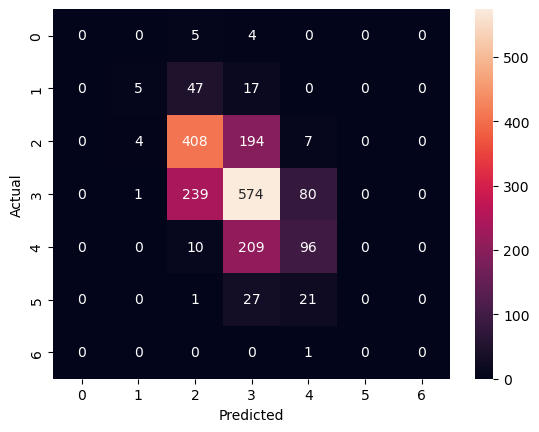

In [10]:
# Evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    predictions = []
    actuals = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.numpy())
            actuals.extend(labels.numpy())
    return predictions, actuals

# Evaluate the model
predictions, actuals = evaluate_model(model, test_loader)

# Display results
print("Accuracy:", accuracy_score(actuals, predictions))
print(classification_report(actuals, predictions))

# Plotting confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_matrix = confusion_matrix(actuals, predictions)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


# Step 5: Mitigation Techniques
We apply four different bias correction methods to the Wine dataset and retrain the model with each method:


### Method 1: Reweighting
Adjust the loss function to give different weights to classes based on their frequency in the training data.

In [11]:
# Reweighting method
class ReweightingLoss(nn.Module):
    def __init__(self, base_criterion, weights):
        super(ReweightingLoss, self).__init__()
        self.base_criterion = base_criterion
        self.weights = weights

    def forward(self, inputs, targets):
        loss = self.base_criterion(inputs, targets)
        weight = self.weights[targets]
        loss = loss * weight
        return loss.mean()

# Calculate class weights
class_counts = np.bincount(y_train.numpy())
total_samples = len(y_train)
class_weights = total_samples / (len(np.unique(y_train)) * class_counts)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Apply reweighting
reweighted_criterion = ReweightingLoss(criterion, class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_model(model, train_loader, reweighted_criterion, optimizer, epochs=50)
predictions, actuals = evaluate_model(model, test_loader)
print("Reweighting Method Accuracy:", accuracy_score(actuals, predictions))
print(classification_report(actuals, predictions))


/tmp/ipykernel_214291/1265665993.py:17: RuntimeWarning: divide by zero encountered in divide
  class_weights = total_samples / (len(np.unique(y_train)) * class_counts)


Epoch 1/50, Loss: 1.1343
Epoch 2/50, Loss: 1.1408
Epoch 3/50, Loss: 1.1237
Epoch 4/50, Loss: 1.0737
Epoch 5/50, Loss: 1.0929
Epoch 6/50, Loss: 1.0979
Epoch 7/50, Loss: 1.0904
Epoch 8/50, Loss: 1.1130
Epoch 9/50, Loss: 1.0591
Epoch 10/50, Loss: 1.0602
Epoch 11/50, Loss: 1.0934
Epoch 12/50, Loss: 1.0673
Epoch 13/50, Loss: 1.0915
Epoch 14/50, Loss: 1.0604
Epoch 15/50, Loss: 1.0521
Epoch 16/50, Loss: 1.0532
Epoch 17/50, Loss: 1.0462
Epoch 18/50, Loss: 1.0534
Epoch 19/50, Loss: 1.0398
Epoch 20/50, Loss: 1.0585
Epoch 21/50, Loss: 1.0240
Epoch 22/50, Loss: 1.0178
Epoch 23/50, Loss: 1.0573
Epoch 24/50, Loss: 1.0669
Epoch 25/50, Loss: 1.0403
Epoch 26/50, Loss: 1.0020
Epoch 27/50, Loss: 1.0291
Epoch 28/50, Loss: 1.0374
Epoch 29/50, Loss: 1.0385
Epoch 30/50, Loss: 1.0138
Epoch 31/50, Loss: 1.0133
Epoch 32/50, Loss: 1.0021
Epoch 33/50, Loss: 1.0059
Epoch 34/50, Loss: 1.0152
Epoch 35/50, Loss: 1.0268
Epoch 36/50, Loss: 1.0067
Epoch 37/50, Loss: 0.9871
Epoch 38/50, Loss: 1.0205
Epoch 39/50, Loss: 1.

/home/amehmood/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amehmood/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/amehmood/anaconda3/envs/main_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_sta

### Method 2: Oversampling
Create more samples of the minority classes by duplicating existing samples, ensuring equal representation of each class.


In [12]:
# # Oversampling method
# from torch.utils.data import WeightedRandomSampler

# # Calculate sample weights
# sample_weights = [class_weights[label] for label in y_train]
# sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# # Create DataLoader with oversampling
# train_loader_oversample = DataLoader(train_dataset, batch_size=16, sampler=sampler)

# # Train with oversampling
# model = WineClassifier()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# train_model(model, train_loader_oversample, criterion, optimizer, epochs=50)
# predictions, actuals = evaluate_model(model, test_loader)
# print("Oversampling Method Accuracy:", accuracy_score(actuals, predictions))
# print(classification_report(actuals, predictions))


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x12 and 13x50)

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler, TensorDataset
from sklearn.metrics import accuracy_score, classification_report
from collections import Counter

# Define the model
class WineClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(WineClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model
input_size = 12  # Update this if needed based on your actual data
hidden_size = 50
output_size = 10  # Adjust this based on the number of classes in your dataset

# Instantiate the model
model = WineClassifier(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the training function
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

# Define the evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    return all_preds, all_labels

# Calculate class weights
class_counts = Counter(y_train.numpy())  # Convert y_train to numpy array for Counter
total_samples = len(y_train)
class_weights = {cls: total_samples / (len(class_counts) * count) for cls, count in class_counts.items()}

# Generate sample weights based on class weights
sample_weights = [class_weights[int(label)] for label in y_train.numpy()]  # Convert tensor labels to integers
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

# Create DataLoader with oversampling
train_loader_oversample = DataLoader(train_dataset, batch_size=16, sampler=sampler)

# Train with oversampling
train_model(model, train_loader_oversample, criterion, optimizer, epochs=50)

# Evaluate the model
predictions, actuals = evaluate_model(model, test_loader)
print("Oversampling Method Accuracy:", accuracy_score(actuals, predictions))
print(classification_report(actuals, predictions))


Epoch 1/50, Loss: 1.7796
Epoch 2/50, Loss: 1.3733
Epoch 3/50, Loss: 1.2501
Epoch 4/50, Loss: 1.1596
Epoch 5/50, Loss: 1.0976
Epoch 6/50, Loss: 1.0517
Epoch 7/50, Loss: 1.0563
Epoch 8/50, Loss: 0.9925
Epoch 9/50, Loss: 0.9968
Epoch 10/50, Loss: 0.9535
Epoch 11/50, Loss: 0.9401
Epoch 12/50, Loss: 0.9205
Epoch 13/50, Loss: 0.9232
Epoch 14/50, Loss: 0.8923
Epoch 15/50, Loss: 0.9017
Epoch 16/50, Loss: 0.8985
Epoch 17/50, Loss: 0.8660
Epoch 18/50, Loss: 0.8507
Epoch 19/50, Loss: 0.8506
Epoch 20/50, Loss: 0.8535
Epoch 21/50, Loss: 0.8337
Epoch 22/50, Loss: 0.8234
Epoch 23/50, Loss: 0.8270
Epoch 24/50, Loss: 0.8232
Epoch 25/50, Loss: 0.8212
Epoch 26/50, Loss: 0.8451
Epoch 27/50, Loss: 0.8265
Epoch 28/50, Loss: 0.8062
Epoch 29/50, Loss: 0.7950
Epoch 30/50, Loss: 0.7966
Epoch 31/50, Loss: 0.7870
Epoch 32/50, Loss: 0.8119
Epoch 33/50, Loss: 0.7937
Epoch 34/50, Loss: 0.7828
Epoch 35/50, Loss: 0.7863
Epoch 36/50, Loss: 0.7769
Epoch 37/50, Loss: 0.7784
Epoch 38/50, Loss: 0.7902
Epoch 39/50, Loss: 0.

### Method 3: Undersampling
Reduce the number of samples from the majority class to match the minority class, balancing class distribution.

In [15]:
# # Undersampling method
# from imblearn.under_sampling import RandomUnderSampler

# # Apply undersampling
# rus = RandomUnderSampler(random_state=42)
# X_resampled, y_resampled = rus.fit_resample(X_train.numpy(), y_train.numpy())

# # Convert back to PyTorch tensors
# X_resampled = torch.tensor(X_resampled, dtype=torch.float32)
# y_resampled = torch.tensor(y_resampled, dtype=torch.long)
# train_dataset_undersample = TensorDataset(X_resampled, y_resampled)
# train_loader_undersample = DataLoader(train_dataset_undersample, batch_size=16, shuffle=True)

# # Train with undersampling
# model = WineClassifier()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# train_model(model, train_loader_undersample, criterion, optimizer, epochs=50)
# predictions, actuals = evaluate_model(model, test_loader)
# print("Undersampling Method Accuracy:", accuracy_score(actuals, predictions))
# print(classification_report(actuals, predictions))


TypeError: __init__() missing 3 required positional arguments: 'input_size', 'hidden_size', and 'output_size'

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, classification_report

# Define the model
class WineClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(WineClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize parameters
input_size = 12  # Number of features
hidden_size = 50
output_size = 10  # Number of classes

# Instantiate the model with the correct parameters
model = WineClassifier(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define the training function
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

# Define the evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    return all_preds, all_labels

# Apply undersampling
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train.numpy(), y_train.numpy())

# Convert back to PyTorch tensors
X_resampled = torch.tensor(X_resampled, dtype=torch.float32)
y_resampled = torch.tensor(y_resampled, dtype=torch.long)
train_dataset_undersample = TensorDataset(X_resampled, y_resampled)
train_loader_undersample = DataLoader(train_dataset_undersample, batch_size=16, shuffle=True)

# Train with undersampling
train_model(model, train_loader_undersample, criterion, optimizer, epochs=50)

# Evaluate the model
predictions, actuals = evaluate_model(model, test_loader)
print("Undersampling Method Accuracy:", accuracy_score(actuals, predictions))
print(classification_report(actuals, predictions))


Epoch 1/50, Loss: 2.3645
Epoch 2/50, Loss: 2.3262
Epoch 3/50, Loss: 2.2920
Epoch 4/50, Loss: 2.2587
Epoch 5/50, Loss: 2.2246
Epoch 6/50, Loss: 2.1923
Epoch 7/50, Loss: 2.1620
Epoch 8/50, Loss: 2.1311
Epoch 9/50, Loss: 2.1001
Epoch 10/50, Loss: 2.0686
Epoch 11/50, Loss: 2.0417
Epoch 12/50, Loss: 2.0130
Epoch 13/50, Loss: 1.9848
Epoch 14/50, Loss: 1.9581
Epoch 15/50, Loss: 1.9308
Epoch 16/50, Loss: 1.9040
Epoch 17/50, Loss: 1.8775
Epoch 18/50, Loss: 1.8524
Epoch 19/50, Loss: 1.8265
Epoch 20/50, Loss: 1.8047
Epoch 21/50, Loss: 1.7785
Epoch 22/50, Loss: 1.7550
Epoch 23/50, Loss: 1.7318
Epoch 24/50, Loss: 1.7080
Epoch 25/50, Loss: 1.6843
Epoch 26/50, Loss: 1.6648
Epoch 27/50, Loss: 1.6418
Epoch 28/50, Loss: 1.6204
Epoch 29/50, Loss: 1.6001
Epoch 30/50, Loss: 1.5797
Epoch 31/50, Loss: 1.5582
Epoch 32/50, Loss: 1.5390
Epoch 33/50, Loss: 1.5193
Epoch 34/50, Loss: 1.4993
Epoch 35/50, Loss: 1.4819
Epoch 36/50, Loss: 1.4616
Epoch 37/50, Loss: 1.4436
Epoch 38/50, Loss: 1.4259
Epoch 39/50, Loss: 1.

### Method 4: Synthetic Minority Over-sampling Technique (SMOTE)
Generate synthetic samples for the minority classes by interpolating between existing samples, balancing class distribution while preserving diversity.

In [19]:
# # SMOTE method
# from imblearn.over_sampling import SMOTE

# # Apply SMOTE
# smote = SMOTE(random_state=42)
# X_resampled, y_resampled = smote.fit_resample(X_train.numpy(), y_train.numpy())

# # Convert back to PyTorch tensors
# X_resampled = torch.tensor(X_resampled, dtype=torch.float32)
# y_resampled = torch.tensor(y_resampled, dtype=torch.long)
# train_dataset_smote = TensorDataset(X_resampled, y_resampled)
# train_loader_smote = DataLoader(train_dataset_smote, batch_size=16, shuffle=True)

# # Train with SMOTE
# model = WineClassifier()
# optimizer = optim.Adam(model.parameters(), lr=0.001)
# train_model(model, train_loader_smote, criterion, optimizer, epochs=50)
# predictions, actuals = evaluate_model(model, test_loader)
# print("SMOTE Method Accuracy:", accuracy_score(actuals, predictions))
# print(classification_report(actuals, predictions))


ValueError: Expected n_neighbors <= n_samples,  but n_samples = 4, n_neighbors = 6

In [20]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim

# Define the model
class WineClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(WineClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize parameters
input_size = 12  # Number of features
hidden_size = 50
output_size = 10  # Number of classes

# Instantiate the model with the correct parameters
model = WineClassifier(input_size, hidden_size, output_size)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Apply SMOTE
smote = SMOTE(random_state=42, k_neighbors=3)  # Set k_neighbors to a value ≤ the minority class size
X_resampled, y_resampled = smote.fit_resample(X_train.numpy(), y_train.numpy())

# Convert back to PyTorch tensors
X_resampled = torch.tensor(X_resampled, dtype=torch.float32)
y_resampled = torch.tensor(y_resampled, dtype=torch.long)
train_dataset_smote = TensorDataset(X_resampled, y_resampled)
train_loader_smote = DataLoader(train_dataset_smote, batch_size=16, shuffle=True)

# Define the training function
def train_model(model, train_loader, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}')

# Define the evaluation function
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    return all_preds, all_labels

# Train with SMOTE
train_model(model, train_loader_smote, criterion, optimizer, epochs=50)

# Evaluate the model
predictions, actuals = evaluate_model(model, test_loader)
print("SMOTE Method Accuracy:", accuracy_score(actuals, predictions))
print(classification_report(actuals, predictions))


Epoch 1/50, Loss: 1.4540
Epoch 2/50, Loss: 1.0964
Epoch 3/50, Loss: 1.0011
Epoch 4/50, Loss: 0.9412
Epoch 5/50, Loss: 0.8977
Epoch 6/50, Loss: 0.8636
Epoch 7/50, Loss: 0.8386
Epoch 8/50, Loss: 0.8175
Epoch 9/50, Loss: 0.7983
Epoch 10/50, Loss: 0.7828
Epoch 11/50, Loss: 0.7699
Epoch 12/50, Loss: 0.7581
Epoch 13/50, Loss: 0.7496
Epoch 14/50, Loss: 0.7396
Epoch 15/50, Loss: 0.7308
Epoch 16/50, Loss: 0.7227
Epoch 17/50, Loss: 0.7144
Epoch 18/50, Loss: 0.7085
Epoch 19/50, Loss: 0.7014
Epoch 20/50, Loss: 0.6959
Epoch 21/50, Loss: 0.6896
Epoch 22/50, Loss: 0.6846
Epoch 23/50, Loss: 0.6792
Epoch 24/50, Loss: 0.6757
Epoch 25/50, Loss: 0.6697
Epoch 26/50, Loss: 0.6651
Epoch 27/50, Loss: 0.6620
Epoch 28/50, Loss: 0.6583
Epoch 29/50, Loss: 0.6536
Epoch 30/50, Loss: 0.6506
Epoch 31/50, Loss: 0.6465
Epoch 32/50, Loss: 0.6438
Epoch 33/50, Loss: 0.6389
Epoch 34/50, Loss: 0.6364
Epoch 35/50, Loss: 0.6342
Epoch 36/50, Loss: 0.6301
Epoch 37/50, Loss: 0.6264
Epoch 38/50, Loss: 0.6244
Epoch 39/50, Loss: 0.

## Results
For each method, we retrain the model and evaluate its performance on the test dataset. We display the accuracy and classification report to compare the effectiveness of each bias correction method.

# Understanding Model Bias vs. Data Bias

**Data Bias**: Occurs when the training data is not representative of the real-world scenario, leading to skewed learning.
**Model Bias**: Arises from the algorithms and methodologies used to train the model, causing systematic errors favoring one outcome over others.

# Objective
We'll identify and address model bias in the Wine dataset, focusing on techniques to mitigate bias resulting from class imbalance.

# Steps

1. **Load and preprocess the Wine dataset**.
2. **Train a biased model** to demonstrate preference for the majority class.
3. **Apply four different techniques** to mitigate this bias.
4. **Evaluate and compare** results quantitatively and qualitatively.

# Step 1: Import Libraries and Load Data
We import necessary libraries and load the Wine dataset. The data is preprocessed, including standardization and conversion to PyTorch tensors.



# Step 3: Train the Biased Model
We train the model using the training dataset, monitoring the loss over epochs to ensure the model is learning.






### Method 3: Undersampling
Reduce the number of samples from the majority class to match the minority class, balancing class distribution.

### Method 4: Synthetic Minority Over-sampling Technique (SMOTE)
Generate synthetic samples for the minority classes by interpolating between existing samples, balancing class distribution while preserving diversity.

# Results
For each method, retrain the model and evaluate its performance on the test dataset. Display accuracy and classification report to compare the effectiveness of each bias correction method.
